In [804]:
#all the necessary packages 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
import pandas as pd
from matplotlib import pyplot
#!pip install xgboost
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier,plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from itertools import compress
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
#!pip install wordcloud
from pylab import rcParams
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [805]:
#loading the Kaggle dataset; source: https://www.kaggle.com/datasnaek/mbti-type
data = pd.read_csv('mbti_1[1].csv') 
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Exploratory analysis

<Figure size 864x288 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 0, 'Personality type')

Text(0, 0.5, 'Number of posts')

Text(0.5, 1.0, 'Distribution of posts by personality type')

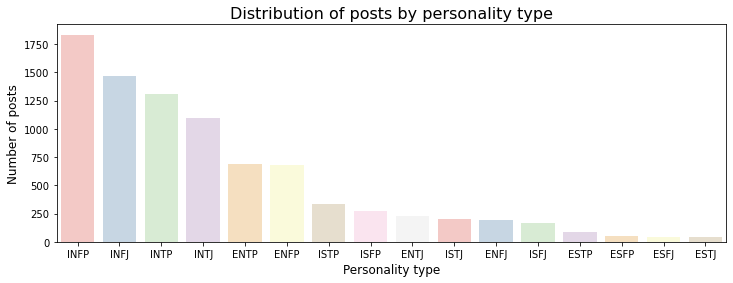

In [806]:
cnt_srs = data['type'].value_counts() #distribution of posts by personality type
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette="Pastel1")
plt.xlabel('Personality type', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)
plt.title('Distribution of posts by personality type', fontsize = 16)
plt.show()

In [807]:
def get_types(row): #binarizing the 4-letter code, with 1 assigned to I,N,T and J letters
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data2 = data.join(data.apply (lambda row: get_types (row),axis=1))
data2.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


<Figure size 576x288 with 0 Axes>

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution accoss type indicators')

([<matplotlib.axis.XTick at 0x7f06a89b4b50>,
 [Text(0, 0, 'I vs. E'),
  Text(1, 0, 'N vs. S'),
  Text(2, 0, 'T vs. F'),
  Text(3, 0, 'J vs. P')])

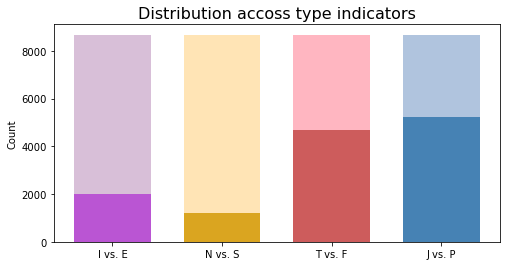

In [808]:
#proportions of posts by each letter
N = 4 
but = (data2['IE'].value_counts()[0], data2['NS'].value_counts()[0], data2['TF'].value_counts()[0], data2['JP'].value_counts()[0])
top = (data2['IE'].value_counts()[1], data2['NS'].value_counts()[1], data2['TF'].value_counts()[1], data2['JP'].value_counts()[1])

ind = np.arange(N)   
width = 0.7     
plt.figure(figsize=(8,4))
p1 = plt.bar(ind, but, width, color=['mediumorchid', 'goldenrod', 'indianred', 'steelblue'])
p2 = plt.bar(ind, top, width, bottom=but, color=['thistle', 'moccasin', 'lightpink', 'lightsteelblue'])

plt.ylabel('Count')
plt.title('Distribution accoss type indicators', fontsize = 16)
plt.xticks(ind, ('I vs. E',  'N vs. S', 'T vs. F', 'J vs. P',))

plt.show()

In [809]:
words = list(data2["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
#Counter(words).most_common(40)

<Figure size 1080x576 with 0 Axes>

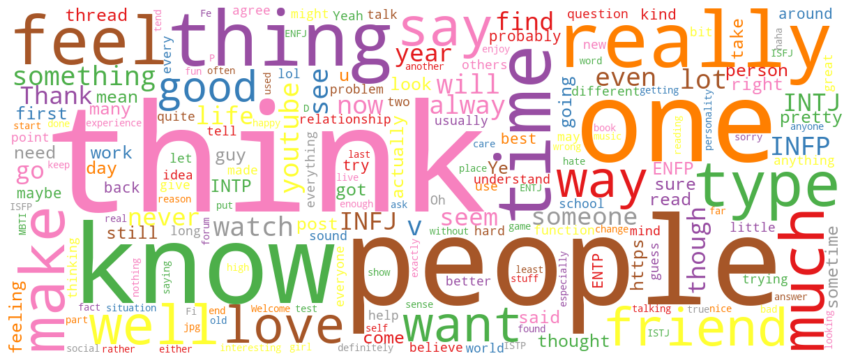

In [810]:
#wordcloud visualizing the frequency of word use 
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="Set1").generate(" ".join(words))

# collocations False to ensure no duplicate words
plt.figure(figsize=(15,8))
# generating the word cloud
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

In [811]:
data['seperated_post'] = data['posts'].apply(lambda x: x.strip().split("|||")) #separate posts
data['num_post'] = data['seperated_post'].apply(lambda x: len(x))

In [812]:
# Expanding the dataframe, giving a unique ID
data['id'] = data.index
expanded_df = pd.DataFrame(data['seperated_post'].tolist(), index=data['id']).stack().reset_index(level=1, drop=True).reset_index(name='idposts')
expanded_df=expanded_df.join(data.set_index('id'), on='id', how = 'left')

In [813]:
expanded_df.head()

,id,idposts,type,posts,seperated_post,num_post
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
2,0,enfp and intj moments https://www.youtube.com...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
3,0,What has been the most life-changing experienc...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50


In [814]:
 #dropping 'posts','seperated_post' and'num_post'
expanded_df=expanded_df.drop(columns=['posts','seperated_post','num_post'])

In [815]:
#lowercasing; removing stopwords, htmls, mbti types names, punctuation; lemmatizing
nltk_stopwords = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()
def clean_text(text):
    result = re.sub(r'http[^\s]*', '',text)
    result = re.sub('[0-9]+','', result).lower()
    result = re.sub('@[a-z0-9]+', 'user', result)
    result = lemmatiser.lemmatize(result)
    return re.sub('[%s]*' % string.punctuation, '',result)

In [816]:
final_df = expanded_df.copy()
final_df['idposts'] = final_df['idposts'].apply(clean_text)

In [817]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords += [',', '\\.', '-', '\'', "’"]
stopwords+=['infj','entp','intp','intj', 'entj','enfj','infp','enfp', 'isfp','istp','isfj','istj', 'estp','esfp','estj','esfj']
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
final_df.idposts = final_df.idposts.str.lower().replace([r'\|', RE_stopwords], [' ', ''], regex=True)

In [818]:
final_df.head()

,id,idposts,type
0,0,,INFJ
1,0,,INFJ
2,0,moments sportscenter top ten plays p...,INFJ
3,0,lifechanging experience life,INFJ
4,0,repeat today,INFJ


### Preparing data for predictive models 

In [822]:
cleaned_df = final_df.groupby('id')['idposts'].apply(list).reset_index()

In [823]:
cleaned_df.head() #final frame to be vectorized

,id,idposts
0,0,"[, , moments sportscenter top ten plays..."
1,1,"[im finding lack posts alarming, sex b..."
2,2,"[good one , course say know thats bl..."
3,3,[dear enjoyed conversation day esoteri...
4,4,"[youre fired, thats another silly misconceptio..."


In [824]:
data['clean_post'] = cleaned_df['idposts'].apply(lambda x: ' '.join(x))

In [825]:
vectorizer = CountVectorizer(stop_words = None,
                            max_features=1500,
                            analyzer="word",
                            max_df=0.8,
                            min_df=0.1)

In [826]:
corpus = data['clean_post'].values.reshape(1,-1).tolist()[0]
vectorizer.fit(corpus)
X_cnt = vectorizer.fit_transform(corpus)

CountVectorizer(max_df=0.8, max_features=1500, min_df=0.1)

In [827]:
# Transform the count matrix to a tf-idf matrix
tfizer = TfidfTransformer()
tfizer.fit(X_cnt)
X = tfizer.fit_transform(X_cnt).toarray()

TfidfTransformer()

In [828]:
X.shape

(8675, 827)

In [829]:
all_words = vectorizer.get_feature_names()
n_words = len(all_words)

In [830]:
data['Extrovert'] = data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
data['Sensing'] = data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
data['Thinking'] = data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
data['Judging'] = data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [485]:
data.head()

,type,posts,seperated_post,num_post,id,clean_post,Extrovert,Sensing,Thinking,Judging
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50,0,moments sportscenter top ten plays ...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50,1,im finding lack posts alarming sex bor...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50,2,good one course say know thats bles...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50,3,dear enjoyed conversation day esoteric...,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50,4,youre fired thats another silly misconception ...,1,0,1,1


In [831]:
X_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(all_words)})

In [832]:
X_df.shape

(8675, 827)

In [4959]:
from sklearn.cluster import KMeans

In [4960]:
km = KMeans().fit(X_df) 
clusters = km.labels_.tolist()
label = kmeans.fit_predict(X_df)
 
#Getting unique labels
u_labels = np.unique(label)

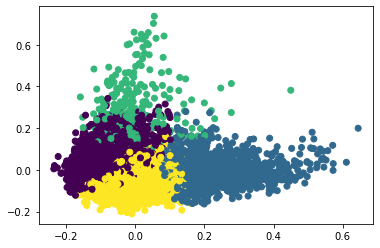

In [4961]:
pca = PCA(n_components=2).fit(X_df) #visualizing the clusters
data2D = pca.transform(X_df)
plt.scatter(data2D[:,0], data2D[:,1], c= kmeans.labels_)
plt.show()   

### Fitting base classifiers

In [4997]:
def sub_classifier_sv(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7, stratify = y_f)
    f_classifier = svm.SVC()
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    
    return f_classifier

In [5060]:
def sub_classifier_sv(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model = svm.SVC()
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [5061]:
extr_classifier_sv = sub_classifier_sv('Extrovert')
sens_classifier_sv = sub_classifier_sv('Sensing')
think_classifier_sv = sub_classifier_sv('Thinking')
judg_classifier_sv = sub_classifier_sv('Judging')

>>> Train classifier ... 
>>> Finish training
Accuracy: 0.8067
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.8620
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.7922
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.7283


In [5042]:
def sub_classifier_knn(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42, stratify = y_f)
    f_classifier = KNeighborsClassifier(n_neighbors=5)
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    
    return f_classifier

In [5064]:
def sub_classifier_knn(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model =KNeighborsClassifier(n_neighbors=5)
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [5065]:
extr_classifier_knn = sub_classifier_knn('Extrovert')
sens_classifier_knn = sub_classifier_knn('Sensing')
think_classifier_knn = sub_classifier_knn('Thinking')
judg_classifier_knn = sub_classifier_knn('Judging')

>>> Train classifier ... 
>>> Finish training
Accuracy: 0.7676
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.8542
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.6378
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.6330


In [4979]:
def sub_classifier_nb(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42, stratify = y_f)
    f_classifier = MultinomialNB()
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [5066]:
def sub_classifier_nb(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model = MultinomialNB()
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [5067]:
extr_classifier_nb = sub_classifier_nb('Extrovert')
sens_classifier_nb = sub_classifier_nb('Sensing')
think_classifier_nb = sub_classifier_nb('Thinking')
judg_classifier_nb = sub_classifier_nb('Judging')

>>> Train classifier ... 
>>> Finish training
Accuracy: 0.7697
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.8620
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.7563
>>> Train classifier ... 
>>> Finish training
Accuracy: 0.6320


In [ ]:
def sub_classifier_lr(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42, stratify = y_f)
    f_classifier = LogisticRegression()
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [ ]:
def sub_classifier_lr(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model = LogisticRegression()
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [ ]:
extr_classifier_lr = sub_classifier_lr('Extrovert')
sens_classifier_lr = sub_classifier_lr('Sensing')
think_classifier_lr = sub_classifier_lr('Thinking')
judg_classifier_lr = sub_classifier_lr('Judging')

In [ ]:
def sub_classifier_rf(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42)
    f_classifier = RandomForestClassifier()
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [ ]:
def sub_classifier_rf(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model = RandomForestClassifier()
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [ ]:
extr_classifier_rf = sub_classifier_rf('Extrovert')
sens_classifier_rf = sub_classifier_rf('Sensing')
think_classifier_rf = sub_classifier_rf('Thinking')
judg_classifier_rf = sub_classifier_rf('Judging')

In [ ]:
def sub_classifier_xg(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42)
    f_classifier = XGBClassifier()
    print(">>> Train classifier ... ")
    f_classifier = XGBClassifier()
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [ ]:
def sub_classifier_xg(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    model = XGBClassifier()
    print(">>> Train classifier ... ")
    scores = cross_val_score(model, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    print(">>> Finish training")
    print('Accuracy: %.4f' % np.mean(scores))
    return f_classifier

In [ ]:
extr_classifier_xg = sub_classifier_xg('Extrovert')
sens_classifier_xg = sub_classifier_xg('Sensing')
think_classifier_xg = sub_classifier_xg('Thinking')
judg_classifier_xg = sub_classifier_xg('Judging')

### Gridsearch for the best parameters

In [ ]:
def sub_classifier_lrh(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42,  stratify=y_f)
    model = LogisticRegression()
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    space = dict()
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    print(">>> Train classifier ... ")
    result = search.fit(X_df, y_f)
    print(">>> Finish training")
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    return f_classifier

In [ ]:
extr_classifier_lrh = sub_classifier_lrh('Extrovert')
sens_classifier_lrh = sub_classifier_lrh('Sensing')
think_classifier_lrh = sub_classifier_lrh('Thinking')
judg_classifier_lrh = sub_classifier_lrh('Judging')

In [ ]:
def sub_classifier_svh(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42,  stratify=y_f)
    model = svm.SVC()
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 
    grid = GridSearchCV(model, param_grid, verbose = 5, cv=cv)
    print(">>> Train classifier ... ")
    result = grid.fit(X_df, y_f)
    print(">>> Finish training")
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    return f_classifier

In [ ]:
extr_classifier_svh = sub_classifier_svh('Extrovert')
sens_classifier_svh = sub_classifier_svh('Sensing')
think_classifier_svh = sub_classifier_svh('Thinking')
judg_classifier_svh = sub_classifier_svh('Judging')

In [ ]:
def sub_classifier_xgbh(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42,  stratify=y_f)
    model =  XGBClassifier()
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    param_grid = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    'max_depth': [2, 3, 5, 6, 7, 8, 10],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'n_estimators': [10, 100,200, 500]}
    search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
    print(">>> Train classifier ... ")
    result = search.fit(X_df, y_f)
    print(">>> Finish training")
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    return f_classifier


In [ ]:
extr_classifier_xgbh = sub_classifier_xgbh('Extrovert')
sens_classifier_xgbh = sub_classifier_xgbh('Sensing')
think_classifier_xgbh = sub_classifier_xgbh('Thinking')
judg_classifier_xgbh = sub_classifier_xgbh('Judging')

In [ ]:
#SGD GridSearch

In [5191]:
def sub_classifier_grid(keyword):
    y_f = data[keyword].values
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42, stratify=y_f)
    
    params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", 'elasticnet', "none"]
   }
    
    f_classifier = SGDClassifier(max_iter=1000)
    clf = GridSearchCV(model, param_grid=params, cv=cv)
    print(">>> Train classifier ... ")
    clf.fit(X_df, y_f)
    print(">>> Finish training")
    print(clf.best_score_)
    print(clf.best_estimator_)
    return f_classifier

In [5192]:
extr_classifier_grid = sub_classifier_grid('Extrovert')
sens_classifier_grid = sub_classifier_grid('Sensing')
think_classifier_grid = sub_classifier_grid('Thinking')
judg_classifier_grid = sub_classifier_grid('Judging')

>>> Train classifier ... 
>>> Finish training
0.814985590778098
SGDClassifier(loss='log', penalty='l1')
>>> Train classifier ... 
>>> Finish training
0.8637463976945245
SGDClassifier(loss='log', penalty='elasticnet')
>>> Train classifier ... 
>>> Finish training
0.7973487031700288
SGDClassifier(loss='log')
>>> Train classifier ... 
>>> Finish training
0.7289913544668588
SGDClassifier(loss='log', penalty='l1')


In [4693]:
#hard and soft voting

In [ ]:
def sub_classifier_soft(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42,  stratify=y_f)
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    estimator = []
    estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l1', solver='liblinear')))
    estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
    estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))
  # Voting Classifier with hard voting
    #vot_hard = VotingClassifier(estimators = estimator, voting ='hard')

# using accuracy_score metric to predict accuracy
    #scores = cross_val_score(vot_hard, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1)
    #print('Accuracy hard: %.4f' % np.mean(scores))
  # Voting Classifier with soft voting
    vot_soft = VotingClassifier(estimators = estimator, voting ='soft')

  # using accuracy_scores and cross validation
    scores2 = cross_val_score(vot_soft, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score="raise")
    print(np.mean(scores2))
#'Accuracy soft: %.4f' %

In [ ]:
extr_classifier_soft = sub_classifier_soft('Extrovert')
sens_classifier_soft = sub_classifier_soft('Sensing')
think_classifier_soft = sub_classifier_soft('Thinking')
judg_classifier_soft = sub_classifier_soft('Judging')

In [ ]:
def sub_classifier_soft2(keyword): #another soft voting to check the accuracy with best logistic regression params for 'sensing'
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=42,  stratify=y_f)
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    estimator = []
    estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l2', solver='newton-cg')))
    estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
    estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))

    vot_soft = VotingClassifier(estimators = estimator, voting ='soft')

  # using accuracy_scores and cross validation
    scores2 = cross_val_score(vot_soft, X_df, y_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score="raise")
    print(np.mean(scores2))

In [ ]:
sens_classifier_soft2 = sub_classifier_soft2('Sensing') #same accuracy as above

In [ ]:
#confusion matrices of the best 3 models so far

In [ ]:
#Extrovert dimension

LogisticRegression(C=1, penalty='l1', solver='liblinear')

array([[1272,   63],
       [ 265,  135]])

<AxesSubplot:>

Text(0.5, 1.0, 'Logistic Regression "I/E" confusion matrix')

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1335
           1       0.68      0.34      0.45       400

    accuracy                           0.81      1735
   macro avg       0.75      0.65      0.67      1735
weighted avg       0.79      0.81      0.79      1735

AUC %s 0.7913932584269664


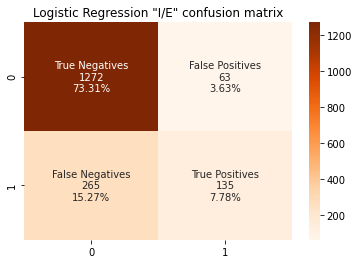

In [798]:
#logistic regression
y_f = data['Extrovert'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
extr_classifier_lrh = LogisticRegression(C=  1, penalty=  'l1', solver= 'liblinear')
extr_classifier_lrh.fit(X_f_train, y_f_train)

y_pred1 = extr_classifier_lrh.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred1)
confmatrix
group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('Logistic Regression "I/E" confusion matrix')

print(classification_report(y_f_test, y_pred1))
print("AUC %s", roc_auc_score(y_f_test, extr_classifier_lrh.predict_proba(X_f_test)[:,1]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:38] WARNING: ../src/learner.cc:573: 
Parameters: { "probability" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:11:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1, solver='newton-cg')),
                             ('SVC',
                              SVC(C=10, gamma=1, kernel='poly',
                                  probability=True)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                               

array([[1282,   53],
       [ 280,  120]])

<AxesSubplot:>

Text(0.5, 1.0, 'Soft Voting "I/E" confusion matrix')

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1335
           1       0.69      0.30      0.42       400

    accuracy                           0.81      1735
   macro avg       0.76      0.63      0.65      1735
weighted avg       0.79      0.81      0.78      1735

AUC %s 0.7923595505617976


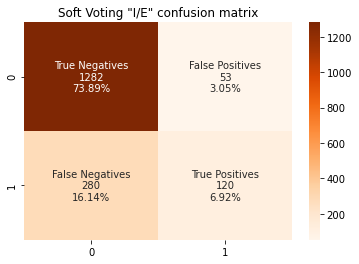

In [799]:
#soft voting
y_f = data['Extrovert'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
estimator = []
estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l2', solver='newton-cg')))
estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))

extr_classifier_soft = VotingClassifier(estimators = estimator, voting ='soft')
extr_classifier_soft.fit(X_f_train, y_f_train)

y_pred1 = extr_classifier_soft.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred1)
confmatrix
group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('Soft Voting "I/E" confusion matrix')

print(classification_report(y_f_test, y_pred1))
print("AUC %s", roc_auc_score(y_f_test, extr_classifier_soft.predict_proba(X_f_test)[:,1]))

SGDClassifier(loss='log', penalty='l1', random_state=42)

array([[1262,   73],
       [ 249,  151]])

<AxesSubplot:>

Text(0.5, 1.0, 'SGD "I/E" confusion matrix')

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1335
           1       0.67      0.38      0.48       400

    accuracy                           0.81      1735
   macro avg       0.75      0.66      0.69      1735
weighted avg       0.80      0.81      0.79      1735

AUC %s 0.7859101123595506


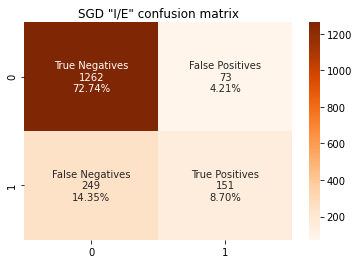

In [797]:
#SGD
y_f = data['Extrovert'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
extr_classifier_final = SGDClassifier(loss = 'log', penalty='l1',  random_state=42)
extr_classifier_final.fit(X_f_train, y_f_train)

y_pred1 = extr_classifier_final.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred)
confmatrix
group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('SGD "I/E" confusion matrix')

print(classification_report(y_f_test, y_pred))
print("AUC %s", roc_auc_score(y_f_test, extr_classifier_final.predict_proba(X_f_test)[:,1]))

In [ ]:
#Sensing dimension

LogisticRegression(C=1, penalty='l1', solver='liblinear')

array([[1487,    9],
       [ 230,    9]])

<AxesSubplot:>

Text(0.5, 1.0, 'Logistic Regression "S/N" confusion matrix')

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1496
           1       0.50      0.04      0.07       239

    accuracy                           0.86      1735
   macro avg       0.68      0.52      0.50      1735
weighted avg       0.82      0.86      0.81      1735

AUC %s 0.7795460139171682


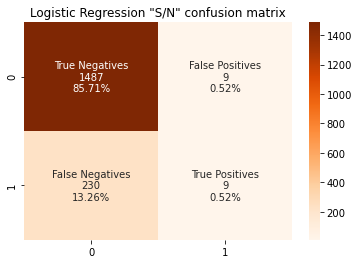

In [800]:
#logistic regression
y_f = data['Sensing'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
sens_classifier_lrh = LogisticRegression(C=  1, penalty=  'l1', solver= 'liblinear')
sens_classifier_lrh.fit(X_f_train, y_f_train)

y_pred2 = sens_classifier_lrh.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred2)
confmatrix

group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('Logistic Regression "S/N" confusion matrix')

print(classification_report(y_f_test, y_pred2))
print("AUC %s", roc_auc_score(y_f_test, sens_classifier_lrh.predict_proba(X_f_test)[:,1]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:13] WARNING: ../src/learner.cc:573: 
Parameters: { "probability" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:14:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1, solver='newton-cg')),
                             ('SVC',
                              SVC(C=10, gamma=1, kernel='poly',
                                  probability=True)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                               

array([[1490,    6],
       [ 230,    9]])

<AxesSubplot:>

Text(0.5, 1.0, 'Soft Voting "S/N" confusion matrix')

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1496
           1       0.60      0.04      0.07       239

    accuracy                           0.86      1735
   macro avg       0.73      0.52      0.50      1735
weighted avg       0.83      0.86      0.81      1735

AUC %s 0.796948067930101


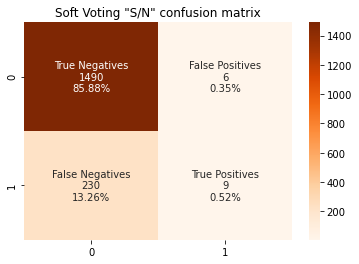

In [801]:
#soft voting
y_f = data['Sensing'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
estimator = []
estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l2', solver='newton-cg')))
estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))

sens_classifier_soft = VotingClassifier(estimators = estimator, voting ='soft')
sens_classifier_soft.fit(X_f_train, y_f_train)

y_pred2 = sens_classifier_soft.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred2)
confmatrix

group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('Soft Voting "S/N" confusion matrix')

print(classification_report(y_f_test, y_pred2))
print("AUC %s", roc_auc_score(y_f_test, sens_classifier_soft.predict_proba(X_f_test)[:,1]))

SGDClassifier(loss='log', penalty='l1', random_state=42)

array([[1470,   26],
       [ 207,   32]])

<AxesSubplot:>

Text(0.5, 1.0, 'SGD "S/N" confusion matrix')

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1496
           1       0.55      0.13      0.22       239

    accuracy                           0.87      1735
   macro avg       0.71      0.56      0.57      1735
weighted avg       0.83      0.87      0.83      1735

AUC %s 0.7728251627771687


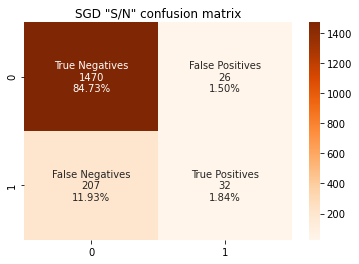

In [803]:
#SGD
y_f = data['Sensing'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
sens_classifier_final = SGDClassifier(loss = 'log', penalty='l1',  random_state=42)
sens_classifier_final.fit(X_f_train, y_f_train)

y_pred2 = sens_classifier_final.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred2)
confmatrix

group_names = ['True Negatives','False Positives','False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmatrix.flatten()/np.sum(confmatrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confmatrix, annot=labels, fmt='', cmap='Oranges')
plt.title('SGD "S/N" confusion matrix')

print(classification_report(y_f_test, y_pred2))
print("AUC %s", roc_auc_score(y_f_test, sens_classifier_final.predict_proba(X_f_test)[:,1]))

In [ ]:
#Thinking dimension

In [232]:
#logistic regression
y_f = data['Thinking'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
think_classifier_lrh = LogisticRegression(C=  1, penalty=  'l1', solver= 'liblinear')
think_classifier_lrh.fit(X_f_train, y_f_train)

y_pred3 = think_classifier_lrh.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred3)
confmatrix

print(classification_report(y_f_test, y_pred3))
print("AUC %s", roc_auc_score(y_f_test, think_classifier_lrh.predict_proba(X_f_test)[:,1]))

LogisticRegression(C=1, penalty='l1', solver='liblinear')

array([[777, 162],
       [174, 622]])

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       939
           1       0.79      0.78      0.79       796

    accuracy                           0.81      1735
   macro avg       0.81      0.80      0.80      1735
weighted avg       0.81      0.81      0.81      1735

AUC %s 0.882542371067264


In [233]:
#soft voting
y_f = data['Thinking'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
estimator = []
estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l2', solver='newton-cg')))
estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))

think_classifier_soft = VotingClassifier(estimators = estimator, voting ='soft')
think_classifier_soft.fit(X_f_train, y_f_train)

y_pred3 = think_classifier_soft.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred3)
confmatrix

print(classification_report(y_f_test, y_pred3))
print("AUC %s", roc_auc_score(y_f_test, think_classifier_soft.predict_proba(X_f_test)[:,1]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:41] WARNING: ../src/learner.cc:573: 
Parameters: { "probability" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:36:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1, solver='newton-cg')),
                             ('SVC',
                              SVC(C=10, gamma=1, kernel='poly',
                                  probability=True)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                               

array([[774, 165],
       [178, 618]])

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       939
           1       0.79      0.78      0.78       796

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80      1735
weighted avg       0.80      0.80      0.80      1735

AUC %s 0.8918808633155126


In [234]:
y_f = data['Thinking'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
think_classifier_final = SGDClassifier(loss = 'log', penalty='l1',  random_state=42)
think_classifier_final.fit(X_f_train, y_f_train)

y_pred3 = think_classifier_final.predict(X_f_test) 

confmatrix3 = confusion_matrix(y_f_test, y_pred3)
confmatrix3

print(classification_report(y_f_test, y_pred3))
print("AUC %s", roc_auc_score(y_f_test, think_classifier_final.predict_proba(X_f_test)[:,1]))

SGDClassifier(loss='log', penalty='l1', random_state=42)

array([[760, 179],
       [168, 628]])

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       939
           1       0.78      0.79      0.78       796

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80      1735
weighted avg       0.80      0.80      0.80      1735

AUC %s 0.8788818961688101


In [ ]:
#Judging dimension

In [235]:
#logistic regression
y_f = data['Judging'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
judg_classifier_lrh = LogisticRegression(C=  1, penalty=  'l1', solver= 'liblinear')
judg_classifier_lrh.fit(X_f_train, y_f_train)

y_pred4 = judg_classifier_lrh.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred4)
confmatrix

print(classification_report(y_f_test, y_pred4))
print("AUC %s", roc_auc_score(y_f_test, judg_classifier_lrh.predict_proba(X_f_test)[:,1]))

LogisticRegression(C=1, penalty='l1', solver='liblinear')

array([[909, 139],
       [312, 375]])

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1048
           1       0.73      0.55      0.62       687

    accuracy                           0.74      1735
   macro avg       0.74      0.71      0.71      1735
weighted avg       0.74      0.74      0.73      1735

AUC %s 0.8041670833472228


In [236]:
#soft voting
y_f = data['Judging'].values
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
estimator = []
estimator.append(('LR', 
                  LogisticRegression(C= 1, penalty= 'l2', solver='newton-cg')))
estimator.append(('SVC', svm.SVC(C= 10, gamma =1, kernel = 'poly', probability=True)))
estimator.append(('XGB', XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth=6, probability=True)))

judg_classifier_soft = VotingClassifier(estimators = estimator, voting ='soft')
judg_classifier_soft.fit(X_f_train, y_f_train)

y_pred4 = judg_classifier_soft.predict(X_f_test) 

confmatrix = confusion_matrix(y_f_test, y_pred4)
confmatrix

print(classification_report(y_f_test, y_pred4))
print("AUC %s", roc_auc_score(y_f_test, judg_classifier_soft.predict_proba(X_f_test)[:,1]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:12] WARNING: ../src/learner.cc:573: 
Parameters: { "probability" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:41:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1, solver='newton-cg')),
                             ('SVC',
                              SVC(C=10, gamma=1, kernel='poly',
                                  probability=True)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                               

array([[919, 129],
       [306, 381]])

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1048
           1       0.75      0.55      0.64       687

    accuracy                           0.75      1735
   macro avg       0.75      0.72      0.72      1735
weighted avg       0.75      0.75      0.74      1735

AUC %s 0.808758903074547


In [237]:
y_f = data['Judging'].values
judg_classifier_final = SGDClassifier(loss = 'log', penalty='l1',  random_state=42)
judg_classifier_final.fit(X_f_train, y_f_train)

y_pred4 = judg_classifier_final.predict(X_f_test) 

confmatrix4 = confusion_matrix(y_f_test, y_pred4)
confmatrix4

print(classification_report(y_f_test, y_pred4))
print("AUC %s", roc_auc_score(y_f_test, judg_classifier_final.predict_proba(X_f_test)[:,1]))

SGDClassifier(loss='log', penalty='l1', random_state=42)

array([[868, 180],
       [265, 422]])

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1048
           1       0.70      0.61      0.65       687

    accuracy                           0.74      1735
   macro avg       0.73      0.72      0.73      1735
weighted avg       0.74      0.74      0.74      1735

AUC %s 0.7996308210273675


In [ ]:
#SGD will be used as the final model for predictions:
def sub_classifier_s(keyword):
    y_f = data[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f,  test_size=0.2, random_state=7,  stratify=y_f)
    f_classifier = SGDClassifier(loss = 'log', penalty='l1',  random_state=42)
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [ ]:
extr_classifier_s= sub_classifier_s('Extrovert')
sens_classifier_s = sub_classifier_s('Sensing')
think_classifier_s = sub_classifier_s('Thinking')
judg_classifier_s = sub_classifier_s('Judging')

### Predicting personality types on company data

In [1056]:
# loading the company data
sww = pd.read_csv('all_pred_93.csv') 
sww.head()
len(sww)

,User ID,First Name,Last Name,Email,Text,Project,Type
0,412722.0,Amandine,Yuan,amandineyuan@foxmail.com,"Hi, my name is Amandine, I’m from China. I thi...",Zest,NaN
1,399152.0,Xinyu,Cheng,maggie.cheng6@hotmail.com,"My name is Xinyu (Maggie), and I am an interio...",Zest,NaN
2,412720.0,Hao,Yang,haoyang0423@gmail.com,This is an energetic girl with a beautiful smi...,Zest,NaN
3,412736.0,Jacky,Au,Rumixhk@hotmail.com,Optimistic energetic persuasive thoughtful sen...,Zest,NaN
4,412721.0,Xin Ran,Liu,ireneliu3234@gmail.com,"My name is XinRan Liu (刘欣然), and my english na...",Zest,NaN


518

In [1057]:
count = sww['Text'].str.split().str.len()

In [1058]:
sww['wordcount'] = count #wordcount of the 'Text' variable to ensure none are shorter than 100 words
sww.head()

,User ID,First Name,Last Name,Email,Text,Project,Type,wordcount
0,412722.0,Amandine,Yuan,amandineyuan@foxmail.com,"Hi, my name is Amandine, I’m from China. I thi...",Zest,NaN,645
1,399152.0,Xinyu,Cheng,maggie.cheng6@hotmail.com,"My name is Xinyu (Maggie), and I am an interio...",Zest,NaN,1116
2,412720.0,Hao,Yang,haoyang0423@gmail.com,This is an energetic girl with a beautiful smi...,Zest,NaN,158
3,412736.0,Jacky,Au,Rumixhk@hotmail.com,Optimistic energetic persuasive thoughtful sen...,Zest,NaN,118
4,412721.0,Xin Ran,Liu,ireneliu3234@gmail.com,"My name is XinRan Liu (刘欣然), and my english na...",Zest,NaN,839


In [1059]:
#chosen projects with the longest qualitative answers to the questions 
short = sww[(sww['wordcount'])<100] #no strings of less than 100 words
len(short)

0

In [1060]:
sww['Text'] = sww['Text'].str.lower() #preparing for predictions - tf-idf matrix
final_test_sww = tfizer.transform(vectorizer.transform([i for i in sww['Text']])).toarray()
test_frame = pd.DataFrame.from_dict({w: final_test_sww[:, i] for i, w in enumerate(all_words)})

In [1061]:
test_frame

,ability,able,absolutely,accept,accurate,across,act,actual,actually,add,...,years,yes,yesterday,yet,youd,youll,young,younger,youre,youve
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.032230,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.018699,0.000000,...,0.021679,0.000000,0.000000,0.027861,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.052357,0.0,0.058433,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0.0,0.000000,0.000000,0.0,0.0,0.074078,0.0,0.000000,0.000000,0.069364,...,0.040707,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
514,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
515,0.0,0.040388,0.097078,0.0,0.0,0.055971,0.0,0.000000,0.000000,0.104818,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
516,0.0,0.046726,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.032005,0.072738,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [1062]:
extr_classifier_final = sub_classifier_s('Extrovert')
sens_classifier_final = sub_classifier_s('Sensing')
think_classifier_final= sub_classifier_s('Thinking')
judg_classifier_final = sub_classifier_s('Judging')

>>> Train classifier ... 
>>> Finish training
Extrovert: 0.2304322766570605
Accuracy Extrovert 0.8144092219020173
AUC Extrovert 0.7859101123595506
>>> Train classifier ... 
>>> Finish training
Sensing: 0.13798270893371758
Accuracy Sensing 0.8657060518731988
AUC Sensing 0.7728251627771687
>>> Train classifier ... 
>>> Finish training
Thinking: 0.4589048991354467
Accuracy Thinking 0.8
AUC Thinking 0.8788818961688101
>>> Train classifier ... 
>>> Finish training
Judging: 0.395850144092219
Accuracy Judging 0.7435158501440923
AUC Judging 0.7996308210273675


In [1063]:
#predicting values for each dimension separately
res_E = extr_classifier_final.predict(test_frame) #I/E
unique, counts = np.unique(res_E, return_counts=True)

#print(np.asarray((unique, counts)).T)

In [1064]:
res_S = sens_classifier_final.predict(test_frame) #N/S
unique, counts = np.unique(res_S, return_counts=True)

#print(np.asarray((unique, counts)).T)

In [1065]:
res_T = think_classifier_final.predict(test_frame) #F/T
unique, counts = np.unique(res_T, return_counts=True)

#print(np.asarray((unique, counts)).T)

In [1066]:
res_J = judg_classifier_final.predict(test_frame) #P/J
unique, counts = np.unique(res_J, return_counts=True)

#print(np.asarray((unique, counts)).T)

In [1067]:
#adding predicted arrays as columns of 0/1 for each letter
sww['Predicted_E'] = res_E 
sww['Predicted_S'] = res_S
sww['Predicted_T'] = res_T
sww['Predicted_J'] = res_J

In [1068]:
def extrovert(row):
    if row['Predicted_E'] == 1 :
        return 'E'
    else:
        return 'I'

In [1069]:
def sensing(row):
    if row['Predicted_S'] == 1 :
        return 'S'
    else:
        return 'N'

In [1070]:
def thinking(row):
    if row['Predicted_T'] == 1 :
        return 'T'
    else:
        return 'F'

In [1071]:
def judging(row):
    if row['Predicted_J'] == 1 :
        return 'J'
    else:
        return 'P'

In [1072]:
sww['E/I'] = sww.apply (lambda row: extrovert(row), axis=1)
sww['S/N'] = sww.apply (lambda row: sensing(row), axis=1)
sww['T/F'] = sww.apply (lambda row: thinking(row), axis=1)
sww['J/P'] = sww.apply (lambda row: judging(row), axis=1)

In [1073]:
sww.head()

,User ID,First Name,Last Name,Email,Text,Project,Type,wordcount,Predicted_E,Predicted_S,Predicted_T,Predicted_J,E/I,S/N,T/F,J/P
0,412722.0,Amandine,Yuan,amandineyuan@foxmail.com,"hi, my name is amandine, i’m from china. i thi...",Zest,NaN,645,0,0,0,0,I,N,F,P
1,399152.0,Xinyu,Cheng,maggie.cheng6@hotmail.com,"my name is xinyu (maggie), and i am an interio...",Zest,NaN,1116,0,0,1,0,I,N,T,P
2,412720.0,Hao,Yang,haoyang0423@gmail.com,this is an energetic girl with a beautiful smi...,Zest,NaN,158,0,0,0,0,I,N,F,P
3,412736.0,Jacky,Au,Rumixhk@hotmail.com,optimistic energetic persuasive thoughtful sen...,Zest,NaN,118,0,1,1,0,I,S,T,P
4,412721.0,Xin Ran,Liu,ireneliu3234@gmail.com,"my name is xinran liu (刘欣然), and my english na...",Zest,NaN,839,0,0,1,0,I,N,T,P


In [1074]:
#concatenating the 4 letter to get the MBTI codes
cols = ['E/I', 'S/N', 'T/F', 'J/P']
sww['Predicted type'] = sww[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [1075]:
sww.head()

,User ID,First Name,Last Name,Email,Text,Project,Type,wordcount,Predicted_E,Predicted_S,Predicted_T,Predicted_J,E/I,S/N,T/F,J/P,Predicted type
0,412722.0,Amandine,Yuan,amandineyuan@foxmail.com,"hi, my name is amandine, i’m from china. i thi...",Zest,NaN,645,0,0,0,0,I,N,F,P,INFP
1,399152.0,Xinyu,Cheng,maggie.cheng6@hotmail.com,"my name is xinyu (maggie), and i am an interio...",Zest,NaN,1116,0,0,1,0,I,N,T,P,INTP
2,412720.0,Hao,Yang,haoyang0423@gmail.com,this is an energetic girl with a beautiful smi...,Zest,NaN,158,0,0,0,0,I,N,F,P,INFP
3,412736.0,Jacky,Au,Rumixhk@hotmail.com,optimistic energetic persuasive thoughtful sen...,Zest,NaN,118,0,1,1,0,I,S,T,P,ISTP
4,412721.0,Xin Ran,Liu,ireneliu3234@gmail.com,"my name is xinran liu (刘欣然), and my english na...",Zest,NaN,839,0,0,1,0,I,N,T,P,INTP


In [1076]:
#filling the missing values in the company data with the predicted types
sww['Type'].fillna(sww['Predicted type'], inplace=True)

### Exploratory analysis of the predicted data

<Figure size 864x288 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 0, 'Personality type')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of past project participants by (predicted) personality type')

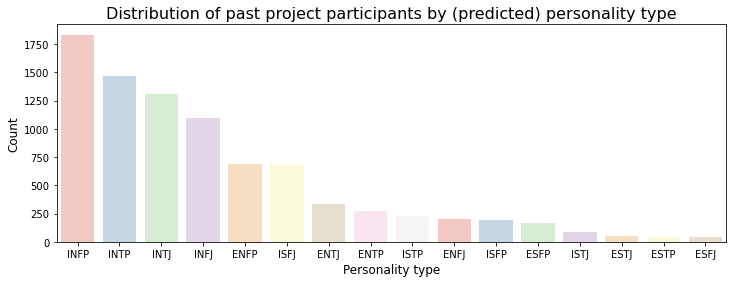

In [1077]:
cnt_srs2 = sww['Type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs2.index, cnt_srs.values, alpha=0.8, palette="Pastel1")
plt.xlabel('Personality type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of past project participants by (predicted) personality type', fontsize = 16)
plt.show()

<Figure size 1440x576 with 0 Axes>

Text(0.5, 1.0, 'Projects by personalities')

[Text(0, 0, 'Splash'),
 Text(1, 0, 'Falafel'),
 Text(2, 0, 'Cypher'),
 Text(3, 0, 'Cupid'),
 Text(4, 0, 'Milkshake'),
 Text(5, 0, 'Rise'),
 Text(6, 0, 'Smoothie'),
 Text(7, 0, 'Stitch'),
 Text(8, 0, 'Goldilocks'),
 Text(9, 0, 'Flux'),
 Text(10, 0, 'Sonic'),
 Text(11, 0, 'Scoville'),
 Text(12, 0, 'Guru'),
 Text(13, 0, 'Boston'),
 Text(14, 0, 'Sprigg'),
 Text(15, 0, 'Hollywood'),
 Text(16, 0, 'Bagel'),
 Text(17, 0, 'Harvest'),
 Text(18, 0, 'Liteyear'),
 Text(19, 0, 'Bagel 2.0'),
 Text(20, 0, 'Crypto'),
 Text(21, 0, 'Zag'),
 Text(22, 0, 'Shine'),
 Text(23, 0, 'Shine 2.0'),
 Text(24, 0, 'Blazer'),
 Text(25, 0, 'Levitate'),
 Text(26, 0, 'Zest'),
 Text(27, 0, 'Luigi'),
 Text(28, 0, 'Dragon'),
 Text(29, 0, 'Tardis')]

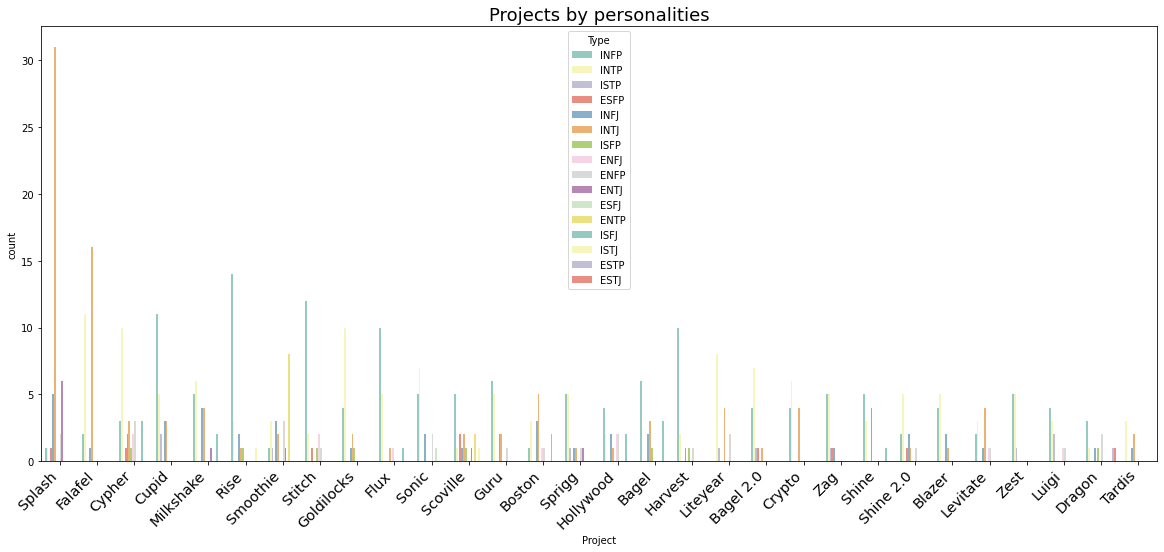

In [1078]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(x = 'Project',
 order = sww['Project'].value_counts(sort=True).index, hue = 'Type' ,
 palette = "Set3", 
 data=sww)
ax.set_title('Projects by personalities', fontsize = 18)
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

<AxesSubplot:ylabel='Project'>

Text(0, 0.5, 'Project')

Text(0.5, 1.0, 'Proportions of personality types on projects')

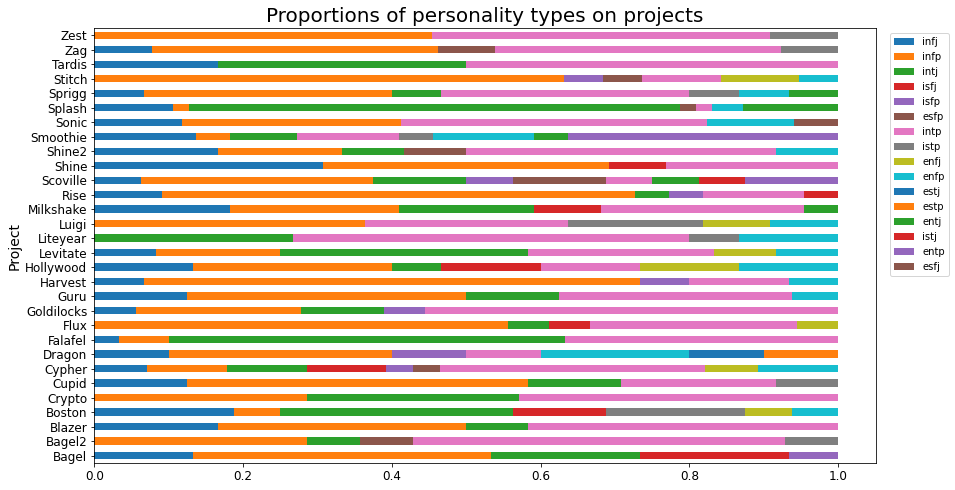

In [1079]:
# plot a Stacked Bar Chart using matplotlib
sww2 = pd.read_csv('proportions.csv')
sww2.plot(
    x = 'Project',fontsize = 12,
    kind = 'barh',
    stacked = True,
    figsize=(14, 8),
    mark_right = True)
plt.ylabel('Project', fontsize = 14)
plt.title('Proportions of personality types on projects', fontsize = 20)
plt.legend(loc="upper right", bbox_to_anchor=(1.10,1), ncol = 1)


### Calculating cognitive diversity scores

In [1080]:
sizes = pd.DataFrame(sww.groupby(['Project']).size()).reset_index()
sizes = sizes.rename(columns={'Project': 'Projects', 0: 'Total'})
sizes

,Projects,Total
0,Bagel,15
1,Bagel 2.0,14
2,Blazer,12
3,Boston,16
4,Crypto,14
5,Cupid,24
6,Cypher,28
7,Dragon,10
8,Falafel,30
9,Flux,18


In [1081]:
#number of each personality type on each project
grouped = pd.DataFrame(sww.groupby(['Project', 'Type']).agg({"Type": "count"}))
grouped.index = grouped.index.set_names(['Project', 'Type'])
grouped.head()

Type
Project Type      
Bagel   INFJ     2
        INFP     6
        INTJ     3
        ISFJ     3
        ISFP     1

In [1082]:
grouped['Projects'] = grouped.index.get_level_values(0)
grouped['Types'] = grouped.index.get_level_values(1)
grouped = grouped[['Projects', 'Types', 'Type' ]].copy()

In [1083]:
grouped = pd.merge(grouped, sizes, on='Projects')
grouped = grouped.rename(columns={'Type': 'Type count on project'})

In [1084]:
grouped.head()

,Projects,Types,Type count on project,Total
0,Bagel,INFJ,2,15
1,Bagel,INFP,6,15
2,Bagel,INTJ,3,15
3,Bagel,ISFJ,3,15
4,Bagel,ISFP,1,15


In [1085]:
grouped['P'] = grouped['Type count on project']/grouped['Total'] #%of all people on project
grouped['log'] = np.log(grouped['P']) #natural logarithm of that %
grouped['product'] = grouped['P']*grouped['log'] #product of P and log

In [1086]:
diversity = pd.DataFrame((grouped.groupby(["Projects"]).product.sum().reset_index()))
diversity= diversity.rename(columns={'product': 'Shannon diversity index'})
#absolute values to get shannon/entropy index
diversity['Shannon diversity index'] = -1 * diversity['Shannon diversity index']

In [1087]:
# % of worldwide/target entropy(shannon) diversity scores
diversity['Normalized Shannon/NH'] = round(diversity['Shannon diversity index']/2.579, 2) 

In [1088]:
diversity.head()

,Projects,Shannon diversity index,Normalized Shannon/NH
0,Bagel,1.459482,0.57
1,Bagel 2.0,1.270018,0.49
2,Blazer,1.236685,0.48
3,Boston,1.771016,0.69
4,Crypto,1.078992,0.42


In [1089]:
#calculating GV/simpson scores
grouped['sim_num'] = grouped['P']*(1-grouped['P'])

In [1090]:
grouped.head()

,Projects,Types,Type count on project,Total,P,log,product,sim_num
0,Bagel,INFJ,2,15,0.133333,-2.014903,-0.268654,0.115556
1,Bagel,INFP,6,15,0.400000,-0.916291,-0.366516,0.240000
2,Bagel,INTJ,3,15,0.200000,-1.609438,-0.321888,0.160000
3,Bagel,ISFJ,3,15,0.200000,-1.609438,-0.321888,0.160000
4,Bagel,ISFP,1,15,0.066667,-2.708050,-0.180537,0.062222


In [1091]:
sim = pd.DataFrame((grouped.groupby(["Projects"]).sim_num.sum().reset_index()))

In [1092]:
diversity["Simpson's index"] = sim['sim_num']

# % of worldwide/target simpson's diversity scores
diversity['Normalized Simpson/NGV'] = round(diversity["Simpson's index"]/0.914, 2)
diversity.head()

,Projects,Shannon diversity index,Normalized Shannon/NH,Simpson's index,Normalized Simpson/NGV
0,Bagel,1.459482,0.57,0.737778,0.81
1,Bagel 2.0,1.270018,0.49,0.653061,0.71
2,Blazer,1.236685,0.48,0.680556,0.74
3,Boston,1.771016,0.69,0.804688,0.88
4,Crypto,1.078992,0.42,0.653061,0.71
5,Cupid,1.411304,0.55,0.708333,0.77
6,Cypher,1.939998,0.75,0.813776,0.89
7,Dragon,1.834372,0.71,0.820000,0.90
8,Falafel,0.997045,0.39,0.575556,0.63
9,Flux,1.164092,0.45,0.604938,0.66


<Figure size 576x288 with 0 Axes>

Text(0.5, 0, 'Normalized Entropy')

Text(0, 0.5, 'Normalized Generalized Variance')

Text(0.5, 1.0, 'NGV and NH scores correlation')

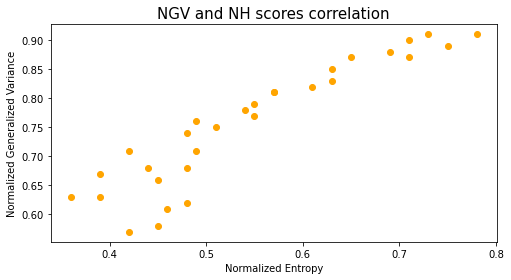

In [1093]:
#comparing the two measures
plt.figure(figsize=(8, 4))
pyplot.scatter(diversity['Normalized Shannon/NH'], diversity['Normalized Simpson/NGV'], color = 'orange')
plt.xlabel('Normalized Entropy')
plt.ylabel('Normalized Generalized Variance')
plt.title('NGV and NH scores correlation', fontsize = 15)#high level of agreement between the measures:

In [1094]:
#correlation between the two diversity measures
corr = np.corrcoef(diversity['Normalized Shannon/NH'], diversity['Normalized Simpson/NGV'])
corr

array([[1.       , 0.9214842],
       [0.9214842, 1.       ]])

In [1096]:
tau, p_value = stats.kendalltau(diversity['Normalized Shannon/NH'], diversity['Normalized Simpson/NGV'])
tau #The Kendall tau rank-order correlation between the two measures

0.8370601014296777

In [1097]:
(1+ tau )/2 #% of pairs are ordered similarly

0.9185300507148388

In [1098]:
p_value 

1.690864190546135e-10

In [1099]:
#distance/proximity to target - global diversity indices
diversity['Distance to target Simpson'] = np.log(abs(diversity['Normalized Simpson/NGV']))
diversity['Distance to target Shannon'] = np.log(abs(diversity['Normalized Shannon/NH']))

In [1100]:
# GV (Simpson) = the probability that two randomly selected individuals from a particular population belong to different subgroups 
# Entropy (Shannon) = average level of "uncertainty" associated with predicting the next individual's subgroup

### Cognitive diversity and innovative project success

In [ ]:
diversity

In [1101]:
#assigning binary 'success' variable: 1 for projects Boston, Hollywood, Levitate, Scoville and Sprigg  
succ = [0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0]
diversity['Success'] = succ

In [1102]:
diversity.head()

,Projects,Shannon diversity index,Normalized Shannon/NH,Simpson's index,Normalized Simpson/NGV,Distance to target Simpson,Distance to target Shannon,Success
0,Bagel,1.459482,0.57,0.737778,0.81,-0.210721,-0.562119,0
1,Bagel 2.0,1.270018,0.49,0.653061,0.71,-0.342490,-0.713350,0
2,Blazer,1.236685,0.48,0.680556,0.74,-0.301105,-0.733969,0
3,Boston,1.771016,0.69,0.804688,0.88,-0.127833,-0.371064,1
4,Crypto,1.078992,0.42,0.653061,0.71,-0.342490,-0.867501,0
5,Cupid,1.411304,0.55,0.708333,0.77,-0.261365,-0.597837,0
6,Cypher,1.939998,0.75,0.813776,0.89,-0.116534,-0.287682,0
7,Dragon,1.834372,0.71,0.820000,0.90,-0.105361,-0.342490,0
8,Falafel,0.997045,0.39,0.575556,0.63,-0.462035,-0.941609,0
9,Flux,1.164092,0.45,0.604938,0.66,-0.415515,-0.798508,0


In [1120]:
diversity = diversity.sort_values(['Normalized Simpson/NGV']).reset_index(drop=True)

<Figure size 864x504 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'NGV')

Text(0, 0.5, 'Project')

Text(0.5, 1.0, "Past projects' NGV cognitive diversity scores")

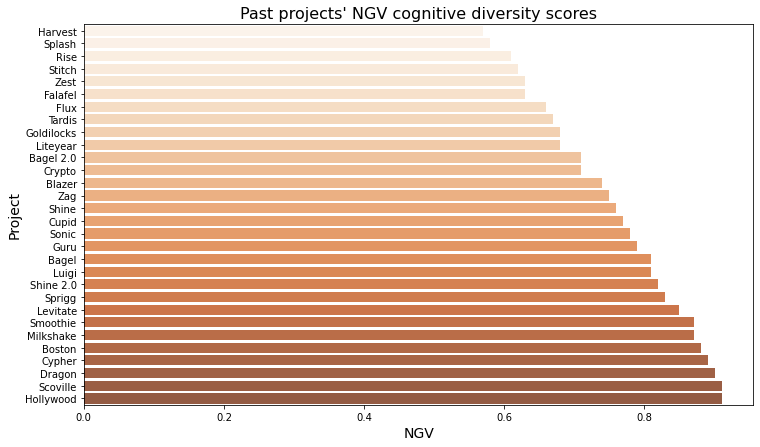

In [1121]:
cnt_srs3 = diversity['Normalized Simpson/NGV'].value_counts()
plt.figure(figsize=(12,7))
l = diversity['Normalized Simpson/NGV'].to_list()
ax = sns.barplot(diversity['Normalized Simpson/NGV'],diversity['Projects'] , alpha=0.8, palette="Oranges")
plt.xlabel('NGV', fontsize=14)
plt.ylabel('Project', fontsize=14)
plt.title("Past projects' NGV cognitive diversity scores", fontsize = 16)
plt.show()

In [1105]:
simp = diversity['Normalized Simpson/NGV']
h = simp.describe()
pd.DataFrame(h)

,Normalized Simpson/NGV
count,30.000000
mean,0.756333
std,0.105618
min,0.570000
25%,0.672500
50%,0.765000
75%,0.845000
max,0.910000


In [1106]:
diversity.groupby(['Success'])['Normalized Simpson/NGV'].mean()

Success
0    0.7324
1    0.8760
Name: Normalized Simpson/NGV, dtype: float64

<AxesSubplot:xlabel='Projects', ylabel='Normalized Simpson/NGV'>

[Text(0.5, 0, 'Project'), Text(0, 0.5, 'NGV')]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Harvest'),
  Text(1, 0, 'Splash'),
  Text(2, 0, 'Rise'),
  Text(3, 0, 'Stitch'),
  Text(4, 0, 'Zest'),
  Text(5, 0, 'Falafel'),
  Text(6, 0, 'Flux'),
  Text(7, 0, 'Tardis'),
  Text(8, 0, 'Goldilocks'),
  Text(9, 0, 'Liteyear'),
  Text(10, 0, 'Bagel 2.0'),
  Text(11, 0, 'Crypto'),
  Text(12, 0, 'Blazer'),
  Text(13, 0, 'Zag'),
  Text(14, 0, 'Shine'),
  Text(15, 0, 'Cupid'),
  Text(16, 0, 'Sonic'),
  Text(17, 0, 'Guru'),
  Text(18, 0, 'Bagel'),
  Text(19, 0, 'Luigi'),
  Text(20, 0, 'Shine 2.0'),
  Text(21, 0, 'Sprigg'),
  Text(22, 0, 'Levitate'),
  Text(23, 0, 'Smoothie'),
  Text(24, 0, 'Milkshake'),
  Text(25, 0, 'Boston'),
  Text(26, 0, 'Cypher'),
  Text(27, 0, 'Dragon'),
  Text(28, 0, 'Scoville'),
  Text(29, 0, 'Hollywood')])

Text(0.5, 1.0, 'Successful/Unsuccessful projects by NGV')

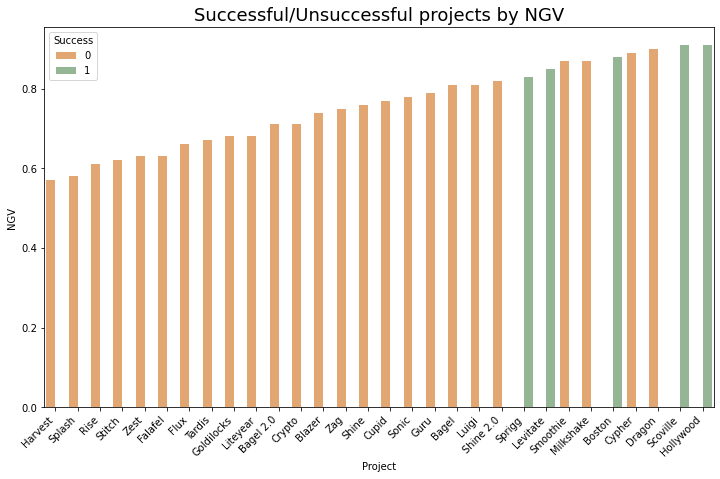

In [1107]:
colors = ['sandybrown', 'darkseagreen']
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(x = 'Projects',
 y = 'Normalized Simpson/NGV', hue = 'Success',
 data = diversity,
 ax = ax, palette = colors)
ax.set(xlabel='Project', ylabel='NGV')
plt.xticks(rotation=45, ha='right',fontsize = 10)
ax.set_title('Successful/Unsuccessful projects by NGV', fontsize = 18)
plt.show()

In [1108]:
pd.DataFrame(diversity["Simpson's index"].describe())
pd.DataFrame(diversity["Shannon diversity index"].describe())

,Simpson's index
count,30.000000
mean,0.693198
std,0.095930
min,0.524444
25%,0.613889
50%,0.703279
75%,0.772222
max,0.835938


,Shannon diversity index
count,30.000000
mean,1.408204
std,0.305339
min,0.934770
25%,1.172773
50%,1.361209
75%,1.634476
max,2.009709


In [1109]:
success = pd.DataFrame(diversity.loc[diversity['Success'] == 1])
no_success = pd.DataFrame(diversity.loc[diversity['Success'] == 0])
success

,Projects,Shannon diversity index,Normalized Shannon/NH,Simpson's index,Normalized Simpson/NGV,Distance to target Simpson,Distance to target Shannon,Success
21,Sprigg,1.635092,0.63,0.755556,0.83,-0.186330,-0.462035,1
22,Levitate,1.632631,0.63,0.777778,0.85,-0.162519,-0.462035,1
25,Boston,1.771016,0.69,0.804688,0.88,-0.127833,-0.371064,1
28,Scoville,2.009709,0.78,0.835938,0.91,-0.094311,-0.248461,1
29,Hollywood,1.876274,0.73,0.835556,0.91,-0.094311,-0.314711,1


In [1111]:
success = success["Normalized Simpson/NGV"]

<Figure size 576x288 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Normalized Generalized Variance score')

Text(0.5, 1.0, 'NGV scores of Successful projects')

Text(0.9636, 14.174999999999986, 'Mean: 0.88')

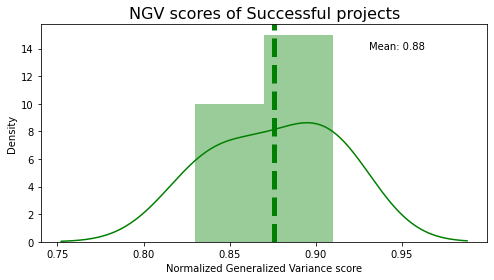

In [1113]:
plt.figure(figsize = (8,4))
ax = sns.distplot(success,  color = 'green')
plt.axvline(np.mean(success), color = 'green', linestyle = 'dashed', linewidth = 5)
_, max_ = plt.ylim()
plt.xlabel('Normalized Generalized Variance score')
plt.title('NGV scores of Successful projects', fontsize = 16)
plt.text(
success.mean()+success.mean()/10,
max_ - max_/10,
'Mean: {:.2f}'.format(success.mean()), ha='right', va='center')

In [1114]:
success.describe()

count    5.000000
mean     0.876000
std      0.035777
min      0.830000
25%      0.850000
50%      0.880000
75%      0.910000
max      0.910000
Name: Normalized Simpson/NGV, dtype: float64

In [1115]:
no_success = no_success["Normalized Simpson/NGV"]

<Figure size 576x288 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'NGV scores of Unsuccessful projects')

Text(0.5, 0, 'Normalized Generalized Variance score')

Text(0.8056399999999998, 3.665454545454545, 'Mean: 0.73')

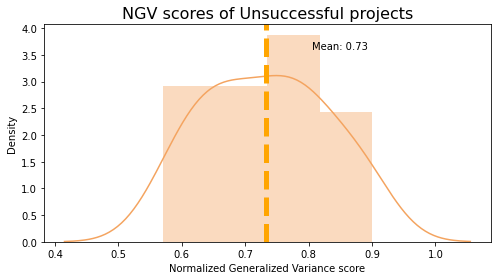

In [1117]:
plt.figure(figsize = (8,4))
ax = sns.distplot(no_success, color = 'sandybrown')
plt.axvline(np.mean(no_success), color = 'orange', linestyle = 'dashed', linewidth = 5)
_, max_ = plt.ylim()
plt.title('NGV scores of Unsuccessful projects', fontsize = 16)
plt.xlabel('Normalized Generalized Variance score')
plt.text(
no_success.mean()+no_success.mean()/10,
max_ - max_/10,
'Mean: {:.2f}'.format(no_success.mean()), ha='left', va='center')

In [1118]:
no_success.describe()

count    25.000000
mean      0.732400
std       0.098416
min       0.570000
25%       0.660000
50%       0.740000
75%       0.810000
max       0.900000
Name: Normalized Simpson/NGV, dtype: float64

<Figure size 576x288 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'NGV distributions comparison of Successful/Unsuccessful projects')

Text(0.5, 0, 'Normalized Generalized Variance score')

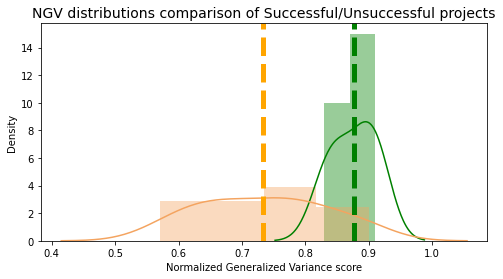

In [1119]:
plt.figure(figsize = (8,4))
ax1 = sns.distplot(success, color = 'green')
ax2 = sns.distplot(no_success, color = 'sandybrown')
plt.axvline(np.mean(success), color = 'green', linestyle = 'dashed', linewidth = 5)
plt.axvline(np.mean(no_success), color = 'orange', linestyle = 'dashed', linewidth = 5)
plt.title('NGV distributions comparison of Successful/Unsuccessful projects', fontsize = 14)
plt.xlabel('Normalized Generalized Variance score')

Hypothesis testing and logistic regression have been performed using R and can be found in the second notebook. 